In [8]:
#@title <font color='Blue'>**Import**</font>
# Load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import random
import scipy.stats as stats
import seaborn as sns
from IPython.core.debugger import set_trace

#Import Model Packages for reinforcement learning
from keras import layers, models, optimizers
from keras import backend as K
from collections import namedtuple, deque
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()


#Diable the warnings
import warnings
warnings.filterwarnings('ignore')

In [9]:
#@title <font color='Blue'>**Condition Setting**</font>
S_0 = 100
K = 100
r = 0
vol = 0.2
T = 1/12
timesteps = 30
seed = 42
n_sims = 50000

In [10]:
#@title <font color='Blue'>**Data Setting**</font>
def monte_carlo_paths(S_0, time_to_expiry, sigma, drift, seed, n_sims, n_timesteps):
    """
    Create random paths of a underlying following a browian geometric motion
    
    input:
    
    S_0 = Spot at t_0
    time_to_experiy = end of the timeseries (last observed time)
    sigma = the volatiltiy (sigma in the geometric brownian motion)
    drift = drift of the process
    n_sims = number of paths to generate
    n_timesteps = numbers of aquidistant time steps 
    
    return:
    
    a (n_timesteps x n_sims x 1) matrix
    """
    if seed > 0:
            np.random.seed(seed)
    stdnorm_random_variates = np.random.randn(n_sims, n_timesteps)
    S = S_0
    dt = time_to_expiry / stdnorm_random_variates.shape[1]
    r = drift
    # See Advanced Monte Carlo methods for barrier and related exotic options by Emmanuel Gobet
    S_T = S * np.cumprod(np.exp((r-sigma**2/2)*dt+sigma*np.sqrt(dt)*stdnorm_random_variates), axis=1)
    return np.reshape(np.transpose(np.c_[np.ones(n_sims)*S_0, S_T]), (n_timesteps+1, n_sims, 1))

# Train the model on the path of the risk neutral measure
paths_train = monte_carlo_paths(S_0, T, vol, r, seed, n_sims, timesteps)

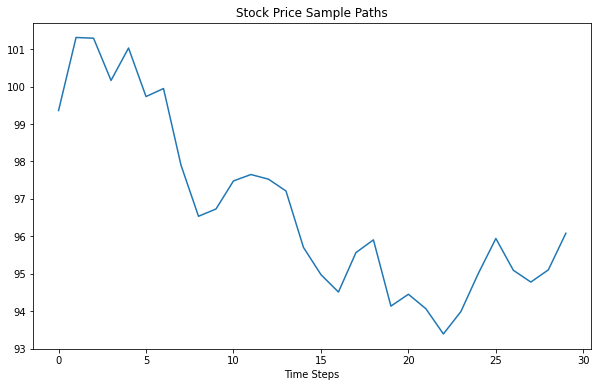

In [5]:
#@title <font color='Blue'>**Plot Paths**</font>
plt.figure(figsize=(10,6))
plt.plot(paths_train[1:31,1])
plt.xlabel('Time Steps')
plt.title('Stock Price Sample Paths')
plt.show()

In [21]:
#@title <font color='Blue'>**Agent Setting**</font>
from IPython.core.debugger import set_trace

class Agent(object):
    def __init__(self, time_steps, batch_size, features, nodes = [62,46,46,1], name='model'):
        # ops.reset_default_graph()
        tf.reset_default_graph()
        self.batch_size = batch_size #NUmber of options in a batch
        self.S_t_input = tf.placeholder(tf.float32, [time_steps, batch_size, features]) #Spot
        self.K = tf.placeholder(tf.float32, batch_size) #Strike 
        self.alpha = tf.placeholder(tf.float32) #alpha for cVaR

        S_T = self.S_t_input[-1,:,0] #Spot at time T
        dS = self.S_t_input[1:, :, 0] - self.S_t_input[0:-1, :, 0] # Change in the Spot price
        #dS = tf.reshape(dS, (time_steps, batch_size))

        #Prepare S_t for the use in the RNN remove the last time step (at T the portfolio is zero)
        S_t = tf.unstack(self.S_t_input[:-1, :,:], axis=0)

        # Build the lstm
        lstm = tf.nn.rnn_cell.MultiRNNCell([tf.nn.rnn_cell.LSTMCell(n) for n in nodes])

        #So the state is a convenient tensor that holds the last actual RNN state, ignoring the zeros. 
        #The strategy tensor holds the outputs of all cells, so it doesn't ignore the zeros. 
        self.strategy, state = tf.nn.static_rnn(lstm, S_t, initial_state=lstm.zero_state(batch_size, tf.float32), \
                                                dtype=tf.float32)

        self.strategy = tf.reshape(self.strategy, (time_steps-1, batch_size))
        self.option = tf.maximum(S_T-self.K, 0)

        self.Hedging_PnL = - self.option + tf.reduce_sum(dS*self.strategy, axis=0)
        self.Hedging_PnL_Paths = - self.option + dS*self.strategy
        # Calculate the CVaR for a given confidence level alpha
        # Take the 1-alpha largest losses (top 1-alpha negative PnLs) and calculate the mean
        CVaR, idx = tf.nn.top_k(-self.Hedging_PnL, tf.cast((1-self.alpha)*batch_size, tf.int32))
        CVaR = tf.reduce_mean(CVaR)
        self.train = tf.train.AdamOptimizer().minimize(CVaR)
        self.saver = tf.train.Saver()
        self.modelname = name
        
    def _execute_graph_batchwise(self, paths, strikes, riskaversion, sess, epochs=1, train_flag=False):
        sample_size = paths.shape[1]
        batch_size=self.batch_size
        idx = np.arange(sample_size)
        start = dt.datetime.now()
        for epoch in range(epochs):
            # Save the hedging Pnl for each batch      
            pnls = []
            strategies = []            
            if train_flag:
                np.random.shuffle(idx)
            for i in range(int(sample_size/batch_size)):
                indices = idx[i*batch_size : (i+1)*batch_size]
                batch = paths[:,indices,:]
                if train_flag:#runs the train, hedging PnL and strategy using the inputs 
                    _, pnl, strategy = sess.run([self.train, self.Hedging_PnL, self.strategy], {self.S_t_input: batch,
                                                                                          self.K : strikes[indices],
                                                                                          self.alpha: riskaversion})
                else:
                    pnl, strategy = sess.run([self.Hedging_PnL, self.strategy], {self.S_t_input: batch,
                                                                                self.K : strikes[indices],
                                                                                self.alpha: riskaversion})
                pnls.append(pnl)
                strategies.append(strategy)
            #Calculate the option prive given the risk aversion level alpha
            #set_trace()
            CVaR = np.mean(-np.sort(np.concatenate(pnls))[:int((1-riskaversion)*sample_size)])
            #set_trace()
            if train_flag:
                if epoch % 10 == 0:
                    print('Time elapsed:', dt.datetime.now()-start)
                    print('Epoch', epoch, 'CVaR', CVaR)
                    #Saving the model
                    self.saver.save(sess, "model.ckpt")
        self.saver.save(sess, "model.ckpt")
        return CVaR, np.concatenate(pnls), np.concatenate(strategies,axis=1)
    
    def training(self, paths, strikes, riskaversion, epochs, session, init=True):
        if init:
            sess.run(tf.global_variables_initializer())
        self._execute_graph_batchwise(paths, strikes, riskaversion, session, epochs, train_flag=True)
        
    def predict(self, paths, strikes, riskaversion, session):
        return self._execute_graph_batchwise(paths, strikes, riskaversion,session, 1, train_flag=False)

    def restore(self, session, checkpoint):
        self.saver.restore(session, checkpoint)

In [22]:
#@title <font color='Blue'>**Model Training**</font>
batch_size = 1000 
features = 1 
K = 100
alpha = 0.50 #risk aversion parameter for cVaR
epoch = 100 #It is set to 100, but should ideally be a high number 
model_1 = Agent(paths_train.shape[0], batch_size, features, name='rnn_final')

# Training the model takes about a few minutes
start = dt.datetime.now()
with tf.Session() as sess:
    # Train Model
    model_1.training(paths_train, np.ones(paths_train.shape[1])*K, alpha, epoch, sess)
print('Training finished, Time elapsed:', dt.datetime.now()-start)

Instructions for updating:
Please use `keras.layers.RNN(cell, unroll=True)`, which is equivalent to this API
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Time elapsed: 0:00:05.103877
Epoch 0 CVaR 3.7730963
Time elapsed: 0:00:18.636519
Epoch 10 CVaR 2.6902287
Time elapsed: 0:00:32.062886
Epoch 20 CVaR 2.6114135
Time elapsed: 0:00:45.487576
Epoch 30 CVaR 2.631829
Time elapsed: 0:00:58.934911
Epoch 40 CVaR 2.590456
Time elapsed: 0:01:12.397212
Epoch 50 CVaR 2.607359
Time elapsed: 0:01:25.815496
Epoch 60 CVaR 2.6463463
Time elapsed: 0:01:39.253895
Epoch 70 CVaR 2.592691
Time elapsed: 0:01:52.669778
Epoch 80 CVaR 2.5860856
Time elapsed: 0:02:06.069709
Epoch 90 CVaR 2.6026323
Training finished, Time elapsed: 0:02:21.539573


In [23]:
#@title <font color='Blue'>**Black Sholes Price and Delta**</font>
def BS_d1(S, dt, r, sigma, K):
    return (np.log(S/K) + (r+sigma**2/2)*dt) / (sigma*np.sqrt(dt))

def BlackScholes_price(S, T, r, sigma, K, t=0):
    dt = T-t
    Phi = stats.norm(loc=0, scale=1).cdf
    d1 = BS_d1(S, dt, r, sigma, K)
    d2 = d1 - sigma*np.sqrt(dt)
    return S*Phi(d1) - K*np.exp(-r*dt)*Phi(d2)

def BS_delta(S, T, r, sigma, K, t=0):
    dt = T-t
    d1 = BS_d1(S, dt, r, sigma, K)
    Phi = stats.norm(loc=0, scale=1).cdf
    return Phi(d1)

In [24]:
#@title <font color='Blue'>**Test Results and Plotting**</font>
def test_hedging_strategy(deltas, paths, K, price, alpha, output=True):
    S_returns = paths[1:,:,0]-paths[:-1,:,0]
    hedge_pnl = np.sum(deltas * S_returns, axis=0)
    option_payoff = np.maximum(paths[-1,:,0] - K, 0)
    replication_portfolio_pnls = -option_payoff + hedge_pnl + price
    mean_pnl = np.mean(replication_portfolio_pnls)
    cvar_pnl = -np.mean(np.sort(replication_portfolio_pnls)[:int((1-alpha)*replication_portfolio_pnls.shape[0])])
    if output:
        plt.hist(replication_portfolio_pnls)
        print('BS price at t0:', price)
        print('Mean Hedging PnL:', mean_pnl)
        print('CVaR Hedging PnL:', cvar_pnl)
    return (mean_pnl, cvar_pnl, hedge_pnl, replication_portfolio_pnls, deltas)

def plot_deltas(paths, deltas_bs, deltas_rnn, times=[0, 1, 5, 10, 15, 29]):
    fig = plt.figure(figsize=(10,6))
    for i, t in enumerate(times):
        plt.subplot(2,3,i+1)
        xs =  paths[t,:,0]
        ys_bs = deltas_bs[t,:]
        ys_rnn = deltas_rnn[t,:]
        df = pd.DataFrame([xs, ys_bs, ys_rnn]).T
        #df = df.groupby(0, as_index=False).agg({1:np.mean,
        #                                          2: np.mean})
        plt.plot(df[0], df[1], df[0], df[2], linestyle='', marker='x' )
        plt.legend(['BS delta', 'RNN Delta'])
        plt.title('Delta at Time %i' % t)
        plt.xlabel('Spot')
        plt.ylabel('$\Delta$')
    plt.tight_layout()
    
def plot_strategy_pnl(portfolio_pnl_bs, portfolio_pnl_rnn):
    fig = plt.figure(figsize=(10,6))
    sns.boxplot(x=['Black-Scholes', 'RNN-LSTM-v1 '], y=[portfolio_pnl_bs, portfolio_pnl_rnn])
    plt.title('Compare PnL Replication Strategy')
    plt.ylabel('PnL')

In [30]:
#@title <font color='Blue'>**Hedging Error for Black Scholes Replication**</font>
def black_scholes_hedge_strategy(S_0, K, r, vol, T, paths, alpha, output):
    bs_price = BlackScholes_price(S_0, T, r, vol, K, 0)
    times = np.zeros(paths.shape[0])
    times[1:] = T / (paths.shape[0]-1)
    times = np.cumsum(times)    
    bs_deltas = np.zeros((paths.shape[0]-1, paths.shape[1]))
    for i in range(paths.shape[0]-1):
        t = times[i]
        bs_deltas[i,:] = BS_delta(paths[i,:,0], T, r, vol, K, t)
    return test_hedging_strategy(bs_deltas, paths, K, bs_price, alpha, output)

In [31]:
#@title <font color='Blue'>**Test at 99% CVaR**</font>
S_0 = 100
K = 100
r = 0
vol = 0.2
T = 1/12
timesteps = 30
seed_test = 21122017
n_sims_test = 10000

# Monte Carlo Path for the test set
alpha = 0.99
paths_test =  monte_carlo_paths(S_0, T, vol, r, seed_test, n_sims_test, timesteps)

with tf.Session() as sess:
    model_1.restore(sess, 'model.ckpt')
    #Using the model_1 trained in the section above
    test1_results = model_1.predict(paths_test, np.ones(paths_test.shape[1])*K, alpha, sess)

BS price at t0: 2.3029744678024286
Mean Hedging PnL: -0.0010458505607415403
CVaR Hedging PnL: 1.2447953011695536
BS price at t0: 2.302974467802428
Mean Hedging PnL: -0.0008085495698080851
CVaR Hedging PnL: 1.3627981412492374


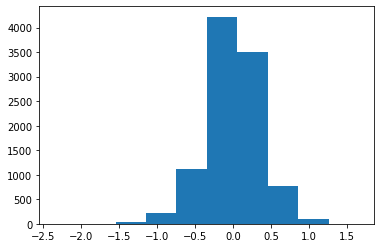

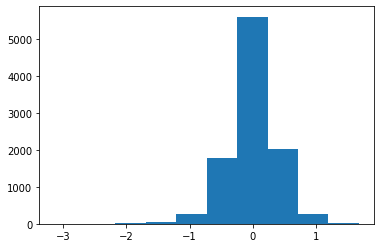

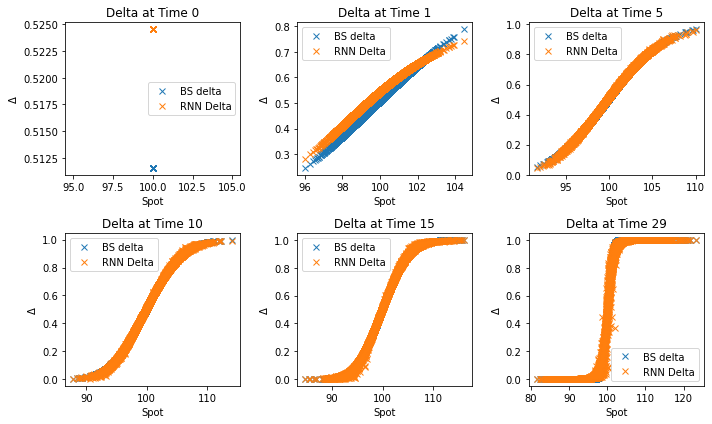

In [33]:
_,_,_,portfolio_pnl_bs, deltas_bs = black_scholes_hedge_strategy(S_0,K, r, vol, T, paths_test, alpha, True)
plt.figure()
_,_,_,portfolio_pnl_rnn, deltas_rnn = test_hedging_strategy(test1_results[2], paths_test, K, 2.302974467802428, alpha, True)
plot_deltas(paths_test, deltas_bs, deltas_rnn)
# plot_strategy_pnl(portfolio_pnl_bs, portfolio_pnl_rnn)

BS price at t0: 10.07339936955367
Mean Hedging PnL: 0.0007508571761945146
CVaR Hedging PnL: 0.6977526775080664
BS price at t0: 10.073
Mean Hedging PnL: -0.03745499635363737
CVaR Hedging PnL: 3.431328261107443


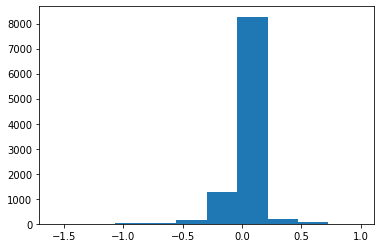

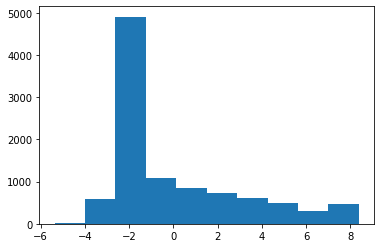

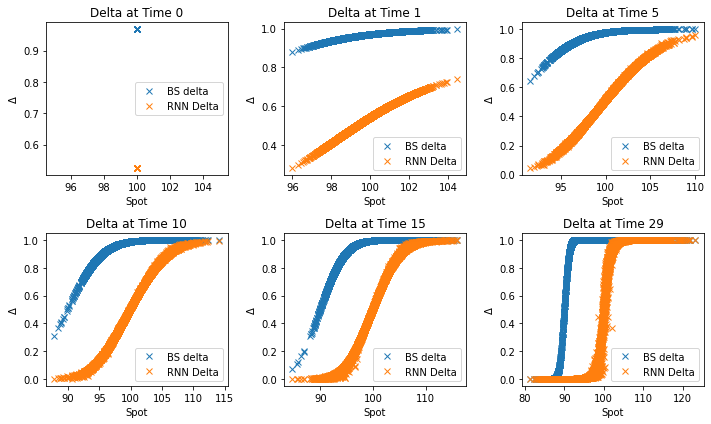

In [35]:
#@title <font color='Blue'>**Changing Moneyness**</font> 
with tf.Session() as sess:
    model_1.restore(sess, 'model.ckpt')
    #Using the model_1 trained in the section above
    test_results_Moneyness = model_1.predict(paths_test, np.ones(paths_test.shape[1])*(K-10), alpha, sess)


_,_,_,portfolio_pnl_bs, deltas_bs = black_scholes_hedge_strategy(S_0,K-10, r, vol, T, paths_test, alpha, True)
plt.figure()
_,_,_,portfolio_pnl_rnn, deltas_rnn = test_hedging_strategy(test_results_Moneyness[2], paths_test, K-10, 10.073, alpha, True)
plot_deltas(paths_test, deltas_bs, deltas_rnn)
# plot_strategy_pnl(portfolio_pnl_bs, portfolio_pnl_rnn)

BS price at t0: 2.3029744678024286
Mean Hedging PnL: -0.017239029648273896
CVaR Hedging PnL: 1.2141220199385756
BS price at t0: 2.3029
Mean Hedging PnL: -0.010639501548581527
CVaR Hedging PnL: 1.3591282767816895


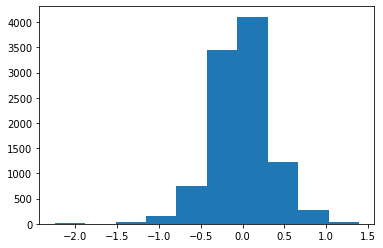

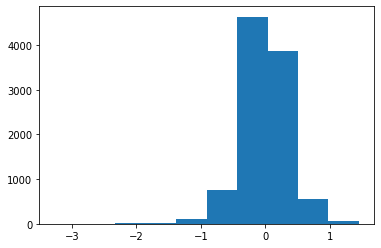

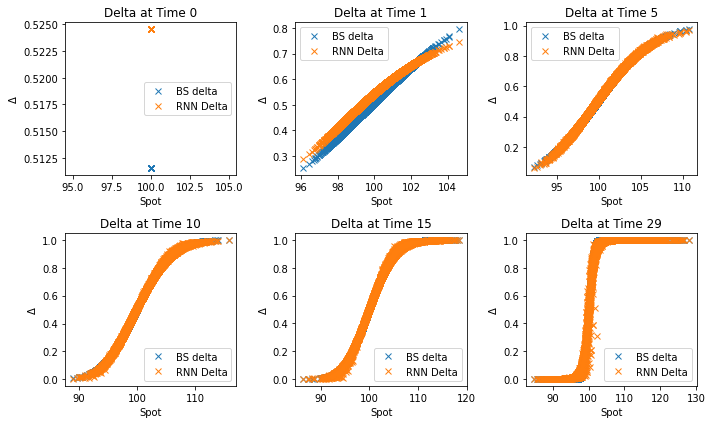

In [37]:
#@title <font color='Blue'>**Changing Drift**</font> 

# Test set 2: Assume the drift of the underlying is 4% per month under the real world measure 
paths_test_drift = monte_carlo_paths(S_0, T, vol, 0.48+r, seed_test, n_sims_test, timesteps)

with tf.Session() as sess:
    model_1.restore(sess, 'model.ckpt')
    #Using the model_1 trained in the section above
    test_results_drift = model_1.predict(paths_test_drift, np.ones(paths_test_drift.shape[1])*K, alpha, sess)

_,_,_,portfolio_pnl_bs, deltas_bs = black_scholes_hedge_strategy(S_0,K,r, vol, T, paths_test_drift, alpha, True)
plt.figure()
_,_,_,portfolio_pnl_rnn, deltas_rnn = test_hedging_strategy(test_results_drift[2], paths_test_drift, K, 2.3029, alpha, True)
plot_deltas(paths_test_drift, deltas_bs, deltas_rnn)
# plot_strategy_pnl(portfolio_pnl_bs, portfolio_pnl_rnn)

BS price at t0: 2.3029744678024286
Mean Hedging PnL: -0.5787493248269506
CVaR Hedging PnL: 2.558392282440757
BS price at t0: 2.309
Mean Hedging PnL: -0.5725806074690319
CVaR Hedging PnL: 2.8529961668213986


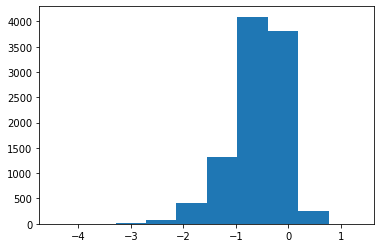

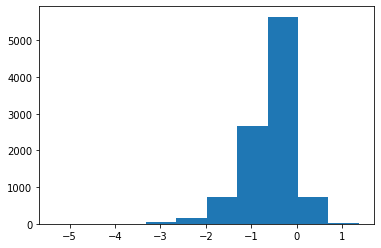

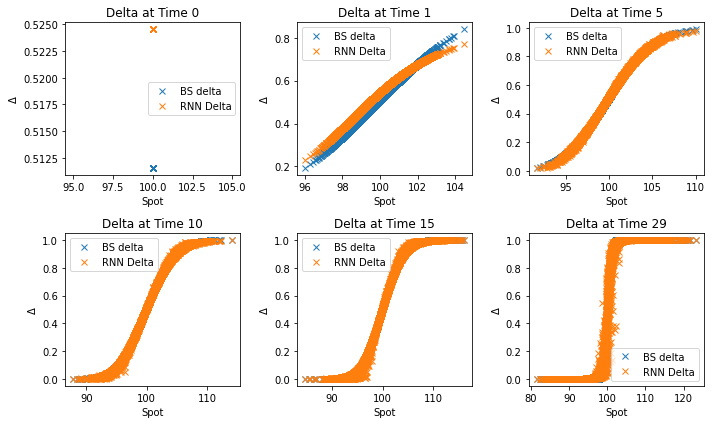

In [39]:
#@title <font color='Blue'>**Shifted Volatility**</font> 

# Test set 3: Assume the volatility is not constant and the realized volatility is 5% higher 
# than the implied (historical observed) one
paths_test_vol = monte_carlo_paths(S_0, T, vol+0.05, r, seed_test, n_sims_test, timesteps)

with tf.Session() as sess:
    model_1.restore(sess, 'model.ckpt')
    #Using the model_1 trained in the section above
    test_results_vol = model_1.predict(paths_test_vol, np.ones(paths_test_vol.shape[1])*K, alpha, sess)
    
_,_,_,portfolio_pnl_bs, deltas_bs = black_scholes_hedge_strategy(S_0,K, r, vol, T, paths_test_vol, alpha, True)
plt.figure()
_,_,_,portfolio_pnl_rnn, deltas_rnn = test_hedging_strategy(test_results_vol[2], paths_test_vol, K, 2.309, alpha, True)
plot_deltas(paths_test, deltas_bs, deltas_rnn)
# plot_strategy_pnl(portfolio_pnl_bs, portfolio_pnl_rnn)

In [40]:
deltas_rnn.shape

(30, 10000)